## Dataset creation notebook

This notebook shows how to build a dataset for the training of a new model in AxonDeepSeg. It covers the following steps:

* How to structure the raw data.
* How to define the parameters of the patch extraction and divide the raw labelled dataset into patches.
* How to generate the training dataset of patches by combining all raw data patches.



### STEP 0: IMPORTS.

In [13]:
from AxonDeepSeg.data_management.dataset_building import split_data, raw_img_to_patches, patched_to_dataset
from AxonDeepSeg.ads_utils import download_data
import os, shutil, time
from pathlib import Path

#modules for visualization at the end
import cv2
from matplotlib import pyplot as plt

#This allows you to import very large images (such as montages)
import PIL
from PIL import Image, ImageOps
PIL.Image.MAX_IMAGE_PIXELS = None

### STEP 1: GENERATE THE DATASET.

### Suggested procedure for training/validation split of the dataset:

* **Example use case:** we have 6 labelled samples in our dataset. To respect the split convention (between 10-30% of samples kept for validation), we can keep 5 samples for the training and the remaining one for the validation. 

---
##### The folder structure *before* the training/validation split:

* ***folder_of_your_raw_data***

     * **sample1**
          * *image.png*
          * *mask.png*
          * *pixel_size_in_micrometer.txt*
     * **sample2**
          * *image.png*
          * *mask.png*
          * *pixel_size_in_micrometer.txt*
            
            ...
            
     * **sample6**
          * *image.png*
          * *mask.png*
          * *pixel_size_in_micrometer.txt*
            
---
#### The folder structure *after* the training/validation split:

* ***folder_of_your_raw_data***

    * **Train**
        * **sample1**
            * *image.png*
            * *mask.png*
            * *pixel_size_in_micrometer.txt*
        * **sample2**
            * *image.png*
            * *mask.png*
            * *pixel_size_in_micrometer.txt*
            
            ...
            
        * **sample5**
            * *image.png*
            * *mask.png*
            * *pixel_size_in_micrometer.txt*
            
    * **Validation**
        * **sample6**
            * *image.png*
            * *mask.png*
            * *pixel_size_in_micrometer.txt*
---         

For this notebook, we'll download a sample dataset hosted on OSF.io that's in the correct raw data folder structure , and use our AxonDeepSeg tools to split the dataset. In the next sections, this notebook will resample the images into patches and group them together in the correct directory structure needed to run the [training guideline notebook](training_guideline.ipynb).

In [14]:
# ****CHANGE BELOW TO NAME OF IMAGE DIRECTORY ***
dataset = "pns"

# define the full path of the images
train_val_path = Path("../data/train_val")
dataset_path = train_val_path / "original" / dataset


In [15]:
# copy data to new folder, as data in this folder will be removed after processing

dataset_copy = dataset + '_copy'
dataset_path_copy = train_val_path / "original" / dataset_copy

if dataset_path_copy.exists():
    shutil.rmtree(dataset_path_copy)

!cp -a $dataset_path/ $dataset_path_copy



In [16]:
# Define the directory names for the dataset building folders

fullsize_split_path = train_val_path / 'fullsize_split' / dataset
crop_perimg_path = train_val_path / 'crop_perimg' /  dataset
crop_path = train_val_path / 'crop' / dataset

# If dataset building folders already exist, remove them.
if fullsize_split_path.exists():
    shutil.rmtree(fullsize_split_path)
if crop_perimg_path.exists():
    shutil.rmtree(crop_perimg_path)
if crop_path.exists():
    shutil.rmtree(crop_path)

In [17]:
# Set seed (changing value will change how the dataset is split)
seed = 2019

# Set dataset split fraction [Train, Validation]
split = [0.8, 0.2]

# Split data into training and validation datasets 
split_data(dataset_path_copy, fullsize_split_path, seed=seed, split=split)

#### 1.1. Define the parameters of the patch extraction.

* **path_raw_data**: Path of the folder that contains the raw data. Each labelled sample of the dataset should be in a different subfolder. For each sample (and subfolder), the expected files are the following:
    * *"image.png"*: The microscopy sample image (uint8 format).
    * *"mask.png"*: The microscopy sample image (uint8 format).
    * *"pixel_size_in_micrometer.txt"*: A one-line text file with the value of the pixel size of the sample. For instance, if the pixel size of the sample is 0.02um, the value in the text file should be **"0.02"**.
    
* **path_patched_data**: Path of the folder that will contain the raw data divided into patches. Each sample (i.e. subfolder) of the raw dataset will be divided into patches and saved in this folder. For instance, if a sample of the original data is divided into 10 patches, the corresponding folder in the **path_patched_dataset** will contain 10 image and mask patches, named **image_0.png** to **image_9.png** and **mask_0.png** to **mask_9.png**, respectively. 

* **patch_size**: The size of the patches in pixels. For instance, a patch size of **128** means that each generated patch will be 128x128 pixels.

* **general_pixel_size**: The pixel size (i.e. resolution) of the generated patches in micrometers. The pixel size will be the same for all generated patches. If the selected pixel size is different from the native pixel sizes of the samples, downsampling or upsampling will be performed. Note that the pixel size should be chosen by taking into account the modality of the dataset and the patch size.  

In [18]:
# Define the paths for the training samples
fullsize_split_train_path = fullsize_split_path / 'Train'
crop_perimg_train_path = crop_perimg_path / 'Train'

# Define the paths for the validation samples
fullsize_split_validation_path = fullsize_split_path / 'Validation'
crop_perimg_validation_path = crop_perimg_path / 'Validation'

patch_size = 512


general_pixel_size = 0.01


In [19]:
txt_filename = str(time.strftime("%Y-%m-%d")) + '_train_val_info.txt'
train_val_info_path = fullsize_split_path / txt_filename


with open(train_val_info_path, 'w') as f:
    f.write(time.strftime("%Y-%m-%d") + '\n\n')
    
    train_imgs = [d.name for d in os.scandir(fullsize_split_train_path) if 'DS_Store' not in str(d)]
    f.write(str(len(train_imgs)) + " training files:" + '\n')
    f.write('\n')
    for img in train_imgs:
        f.write(img + '\n')
    f.write('\n')
    
    val_imgs = [d.name for d in os.scandir(fullsize_split_validation_path) if 'DS_Store' not in str(d)]
    f.write(str(len(val_imgs))+ " validation files:" + '\n')
    f.write('\n')
    for img in val_imgs:
        f.write(img + '\n')
    f.write('\n')   
    f.write("Pixel size after resizing: " + str(general_pixel_size))
    f.close()

#### 1.2. Divide the training/validation samples into patches.

In the **path_patched_data** folder defined above, the original samples are going to be split into patches of same size. For instance, the sample 1 of the training set of the example use case above will be split into *n* patches and its corresponding subfolder in the **path_patched_data** folder will have the following structure:

---
* ***folder_of_your_patched_data***

    * **Train**
        * **sample1**
            * *image_0.png*
            * *mask_0.png*
            * *image_1.png* 
            * *mask_1.png*
            * *image_2.png*
            * *mask_2.png*
            
            ...
            
            * *image_n.png* 
            * *mask_n.png*        
---


* Run the *raw_img_to_patches* function on both *Train* and *Validation* subfolders to split the data into patches. Note the input param. **thresh_indices** is a list of the threshold values to use in order to generate the classes of the training masks. The default value is [0, 0.2, 0.8], meaning that the mask labels (background=0, myelin=0.5, axon=1) will be split into our 3 classes.

In [24]:
# Split the *Train* dataset into patches
raw_img_to_patches(fullsize_split_train_path, crop_perimg_train_path, thresh_indices = [0, 0.2, 0.8], patch_size=patch_size, resampling_resolution=general_pixel_size)


# Split the *Validation* dataset into patches
#raw_img_to_patches(fullsize_split_validation_path, crop_perimg_validation_path, thresh_indices = [0, 0.2, 0.8], patch_size=patch_size, resampling_resolution=general_pixel_size)



 50%|█████     | 1/2 [00:01<00:01,  1.34s/it]


ValueError: 
Error: patch size must be smaller than dimensions of image.

#### 1.3. Regroup all the divided patches in the same training/validation folder.

Finally, to build the dataset folder that is going to be used for the training, all patches obtained from the different samples are regrouped into the same folder and renamed. The final training and validation folders will have the following structure (*m* is the total number of training patches and *p* is the total number of validation patches):

---
* ***folder_of_your_final_patched_data***

    * **Train**
         * *image_0.png*
         * *mask_0.png*
         * *image_1.png* 
         * *mask_1.png*
         * *image_2.png*
         * *mask_2.png*
            
         ...
           
         * *image_m.png* 
         * *mask_m.png*   
         
    * **Validation**
         * *image_0.png*
         * *mask_0.png*
         * *image_1.png* 
         * *mask_1.png*
         * *image_2.png*
         * *mask_2.png*
            
         ...
           
         * *image_p.png* 
         * *mask_p.png*         
         
---

Note that we define a random seed in the input of the *patched_to_dataset* function in order to reproduce the exact same images each time we run the function. This is done to enable the generation of the same training and validation sets (for reproducibility). Also note that the **type_** input argument of the function can be set to **"unique"** or **"mixed"** to specify if the generated dataset comes from the same modality, or contains more than one modality.

In [25]:
# Path of the final training dataset
crop_train_path = crop_path / 'Train'

# Path of the final validation dataset
crop_val_path = crop_path / 'Validation'

In [26]:
# Regroup all training patches
patched_to_dataset(crop_perimg_train_path, crop_train_path, type_='unique', random_seed=2017)

# Regroup all validation patches
patched_to_dataset(crop_perimg_validation_path, crop_val_path, type_='unique', random_seed=2017)


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


In [27]:
# Remove intermediate dataset building folders

if crop_perimg_path.exists():   
    shutil.rmtree(crop_perimg_path)
if dataset_path_copy.exists():
    shutil.rmtree(dataset_path_copy)

../data/train_val/crop_perimg/pns


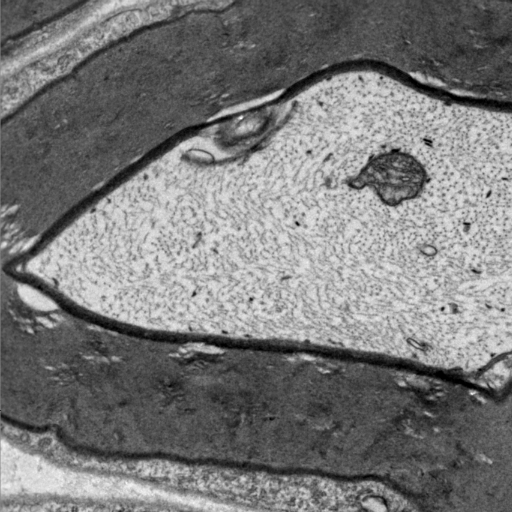

In [28]:
#Optional: visualize one of the image patches

from IPython.display import Image
Image(filename= crop_train_path / 'image_0.png') 

## Next step

Now that you've resampled, patched, and organized your data correctly, the next step is to run the [training guideline notebook](training_guideline.ipynb).